# EG24 CITE-seq and flow cytometry comparisons

In this notebook 2-component Gaussian mixture model (GMM) is used to separate background signal from true signal. For some of the Easigenomics samples, blast phenotype data from flow cytometry is available, here this flow data is compared to CITE-seq results. Model is applied for both CLR and DSB normalized protein counts. 

Only one sample (all cells selected) is used to train the model.


### Sample information:
- ALL
- relapse
- 80% of bone marrow cells are blasts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
from ridgeplot import ridgeplot

import sklearn.mixture

import warnings

warnings.filterwarnings('ignore')

Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Preparing files

In [26]:
#raw protein data, all datasets, raw + CLR and DSB normalized

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

adata.shape

(121340, 8051)

In [27]:
#select sample
adata_sample=adata[adata.obs['eg_code'] == 'EG24']

In [31]:
#all cells, CLR normalized proteins

prot_clr=adata_sample.obsm['protein_expression_clr']

prot_clr.shape

(1067, 33)

In [30]:
#all cells, CLR normalized proteins

prot_dsb=adata_sample.obsm['protein_expression_dsb']

prot_dsb.shape

(1067, 33)

In [32]:
#convert excel to csv (flow data)

read_file = pd.read_excel (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.xlsx')
read_file.to_csv (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv', index = None, header=True)

In [33]:
#get flow data

flow= pd.read_csv('/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv')

### Depending on used dataset, celltype annotations are varying (made by different groups). "new_cell_types" is made based on these, it is a "standardized" version of cell type annotations. 

In [34]:
#Cell types offered by new_cell_type

adata.obs['new_cell_type'].unique().tolist()

['NK',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [35]:
#cell type annotations offered by cell_type

adata.obs['cell_type'].unique().tolist()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

## CLR normalized



In [37]:
#flow results for selected sample

egflow=flow[flow['EG_code'] == 'EG24'].dropna(axis=1)

egflow

,EG_code,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,EG24,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


In [38]:
#drop EG_code

egflow=egflow.drop("EG_code", axis=1)

egflow

,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


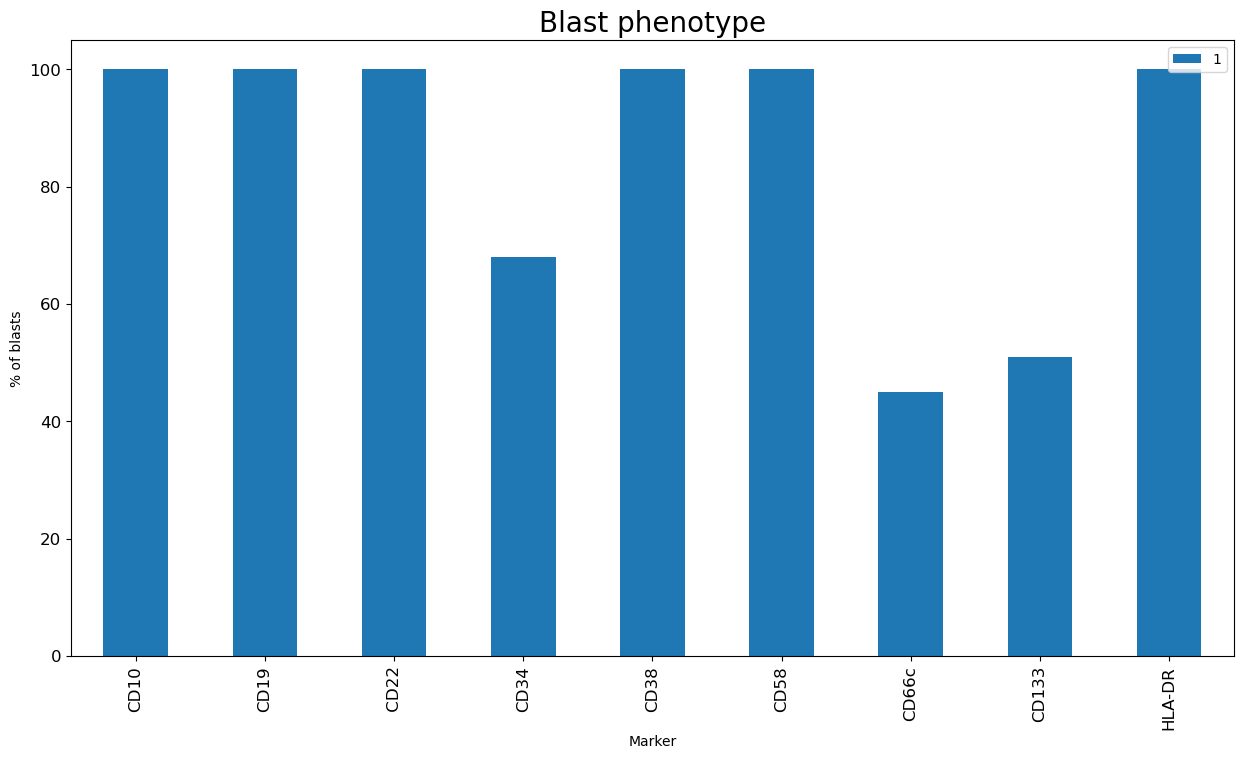

In [39]:
df=egflow * 100 #multiplied by 100 to get percentages

df1=df.T

df1.plot.bar(xlabel="Marker", ylabel="% of blasts",
            figsize= (15,8),
           fontsize="large") ;

plt.title('Blast phenotype', fontsize=20) ;

In [40]:
egflow=egflow*100

In [41]:
flow_markers=egflow.columns
flow_markers

Index(['CD10', 'CD19', ' CD22', 'CD34', 'CD38', 'CD58', 'CD66c', 'CD133',
       'HLA-DR'],
      dtype='object')

In [42]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_clr.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


In [43]:
prot_clr.shape

(1067, 33)

In [44]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

Silhuette score: 0.526127865093167
Percentage of positive cells, based on GMM: 86.5979381443299


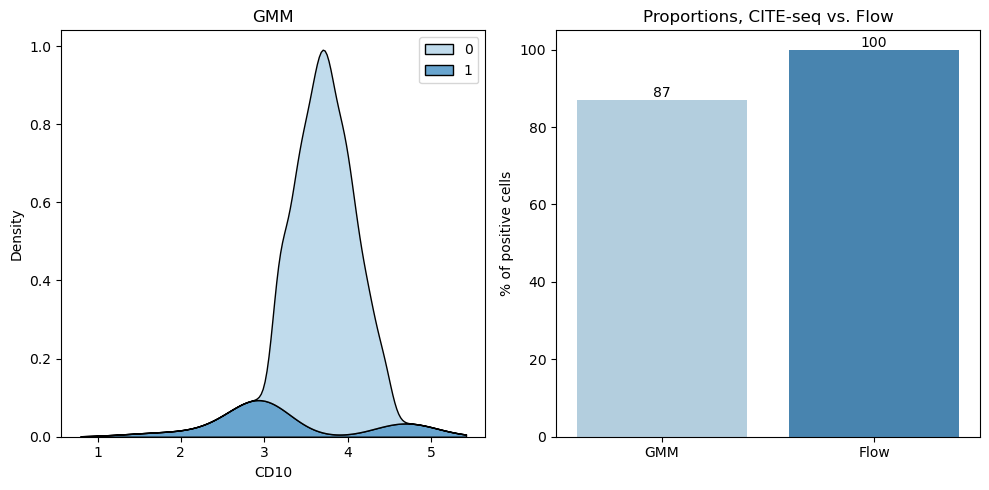

Silhuette score: 0.5535442915883672
Percentage of positive cells, based on GMM: 60.35613870665417


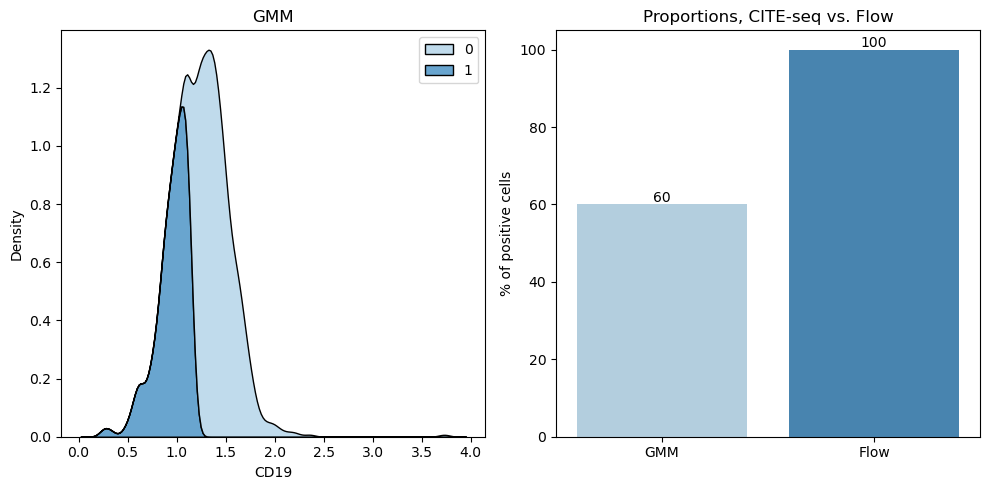

Silhuette score: 0.5607593567671326
Percentage of positive cells, based on GMM: 48.92221180880975


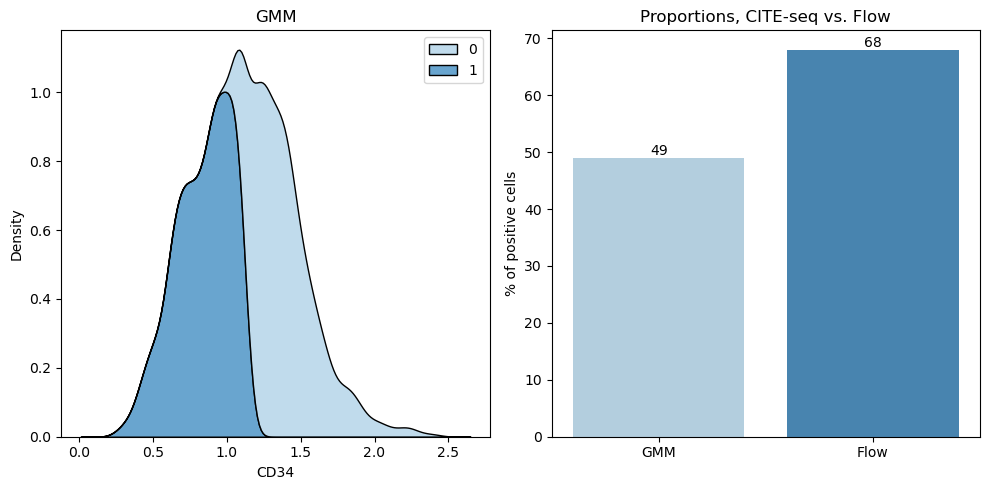

Silhuette score: 0.5716840864118458
Percentage of positive cells, based on GMM: 35.520149953139644


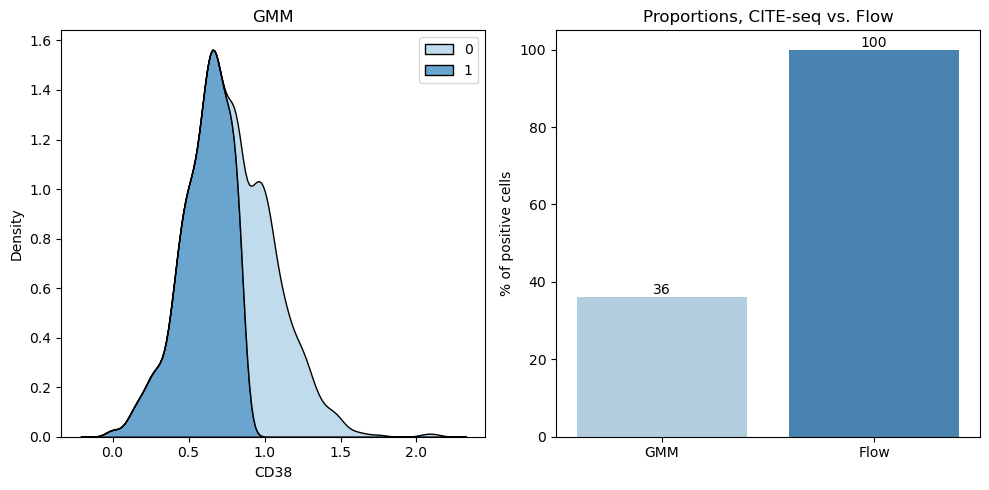

Silhuette score: 0.791499999605645
Percentage of positive cells, based on GMM: 1.0309278350515463


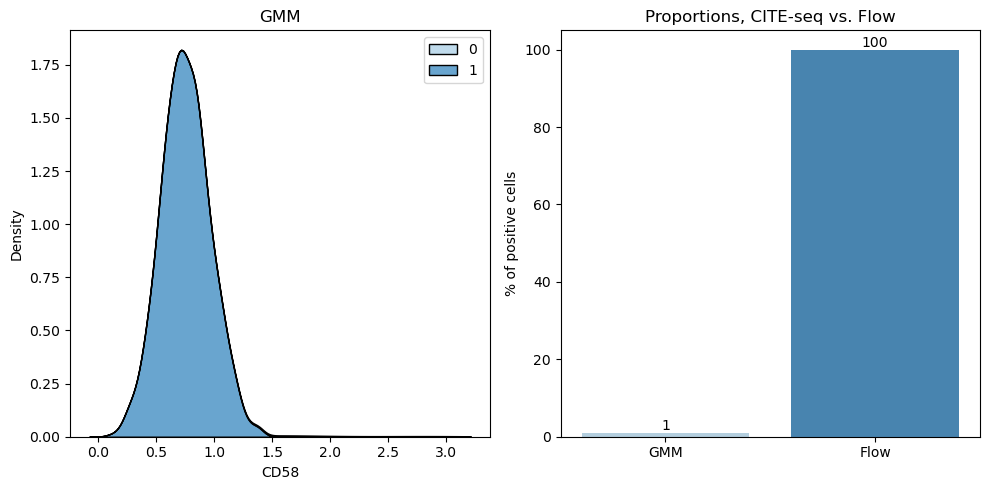

In [47]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_diag = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.526127865093167
Percentage of positive cells, based on GMM: 86.5979381443299


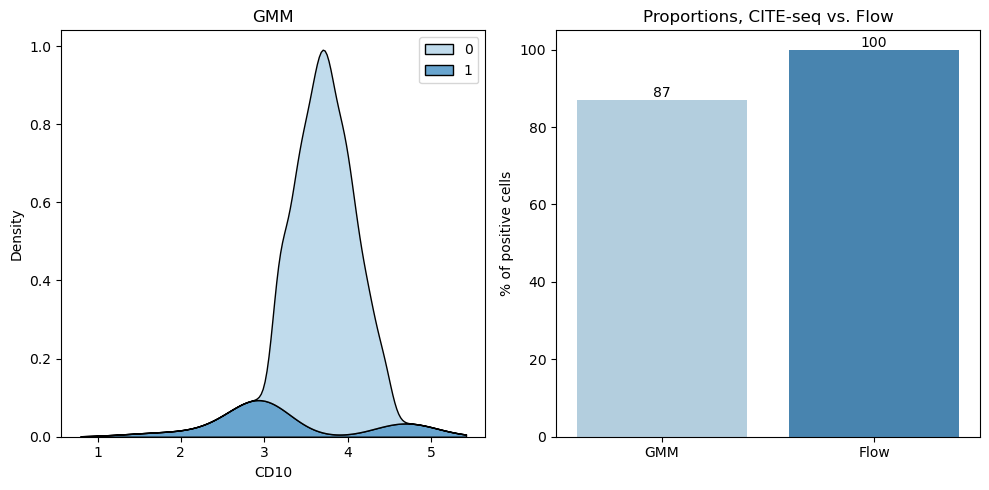

Silhuette score: 0.5535442915883672
Percentage of positive cells, based on GMM: 60.35613870665417


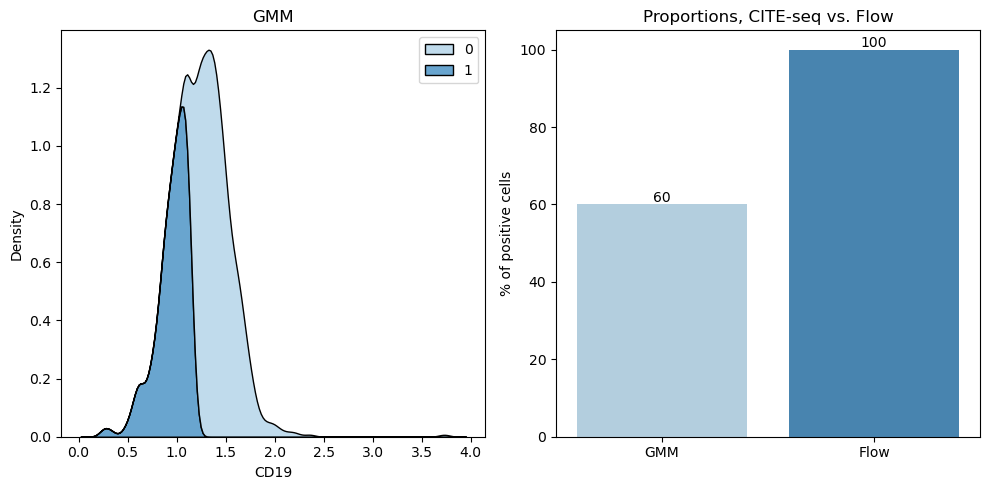

Silhuette score: 0.5607593567671326
Percentage of positive cells, based on GMM: 48.92221180880975


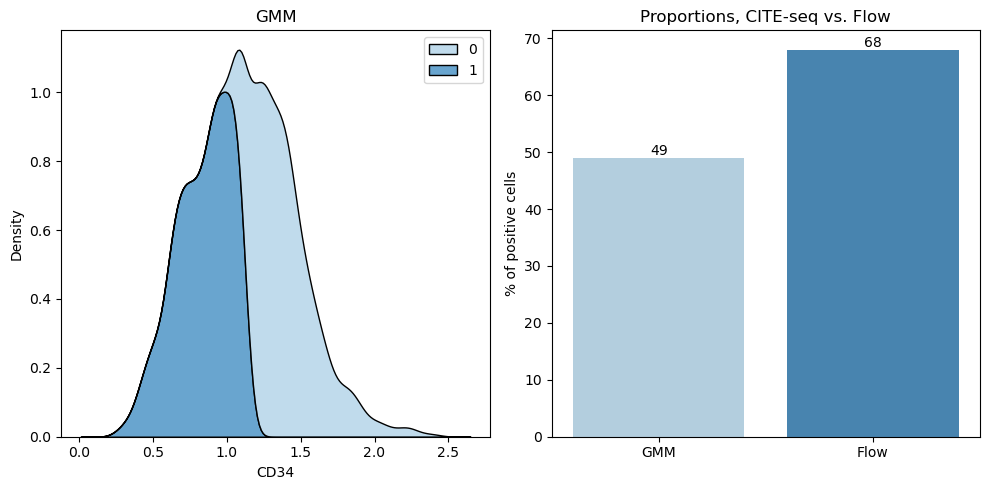

Silhuette score: 0.5716840864118458
Percentage of positive cells, based on GMM: 35.520149953139644


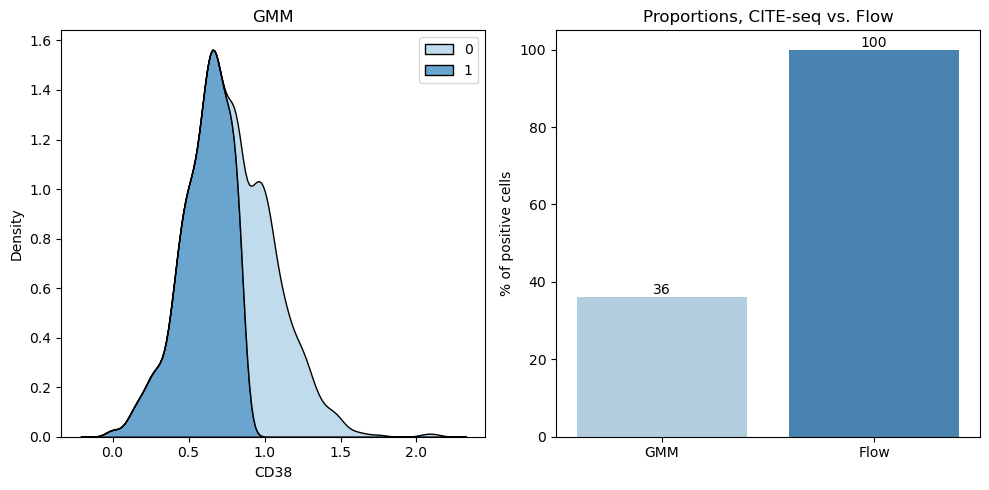

Silhuette score: 0.791499999605645
Percentage of positive cells, based on GMM: 1.0309278350515463


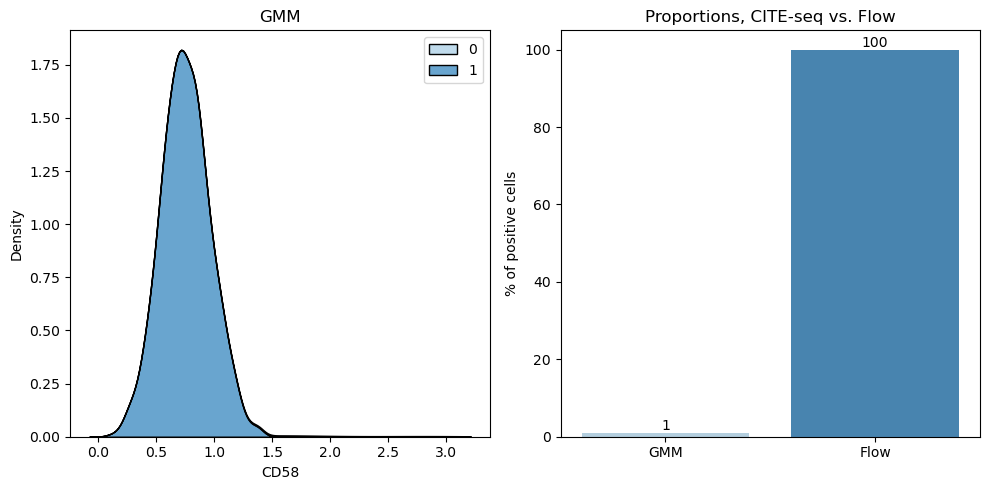

In [48]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_spher = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5318044902120391
Percentage of positive cells, based on GMM: 83.88003748828491


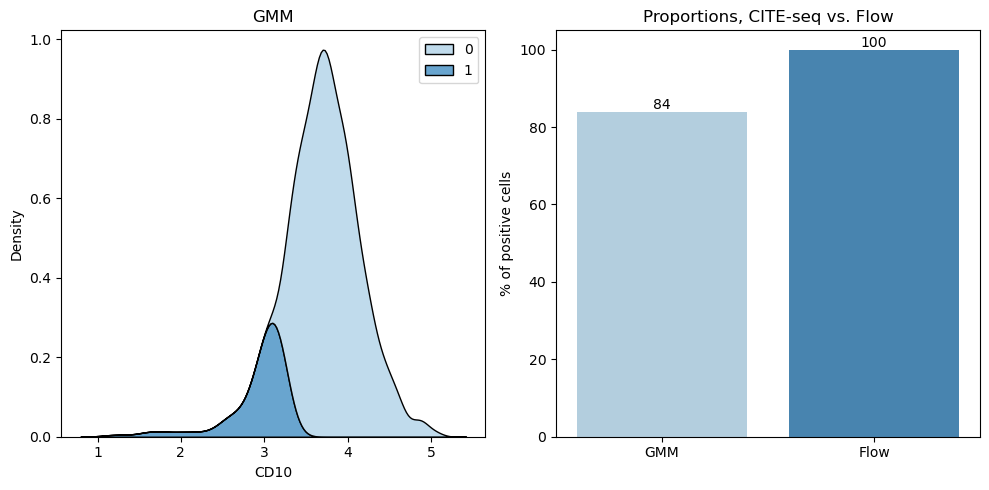

Silhuette score: 0.5580978189315434
Percentage of positive cells, based on GMM: 56.888472352389876


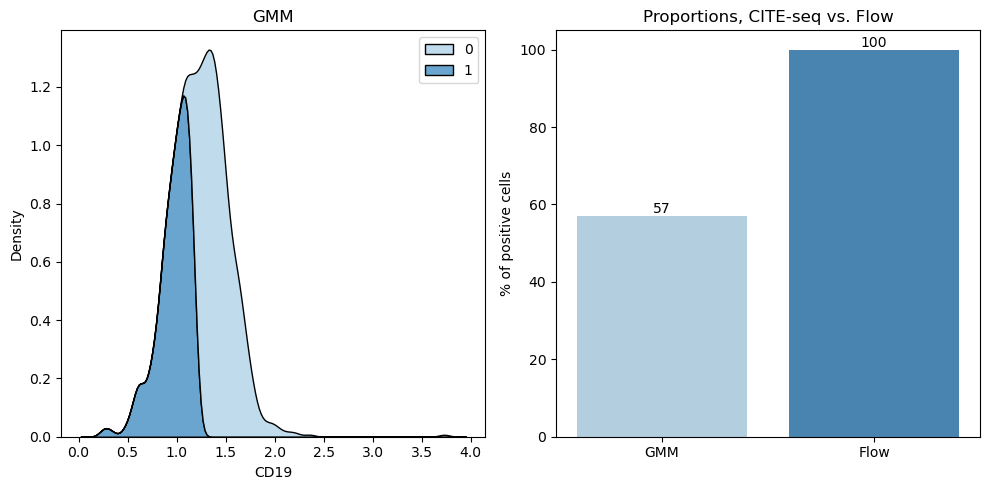

Silhuette score: 0.559520795576175
Percentage of positive cells, based on GMM: 43.58013120899719


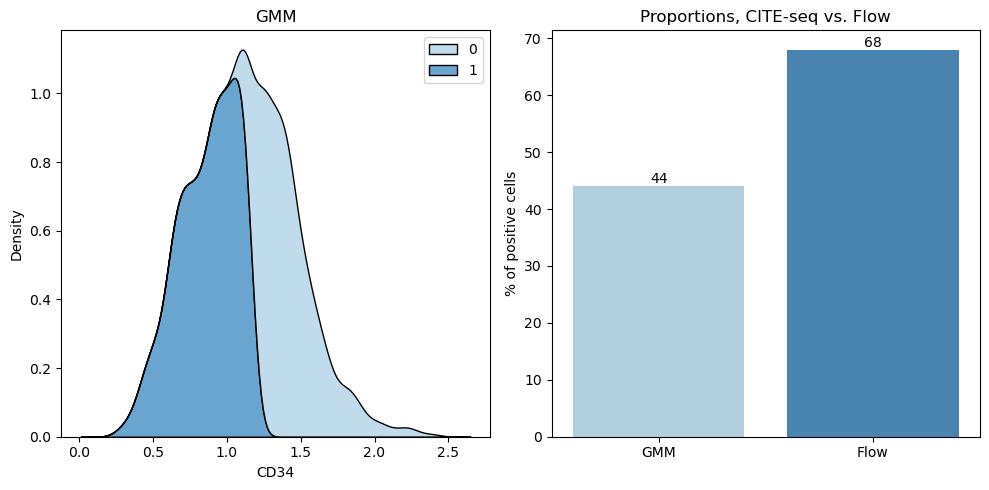

Silhuette score: 0.5636509125825852
Percentage of positive cells, based on GMM: 31.58388003748828


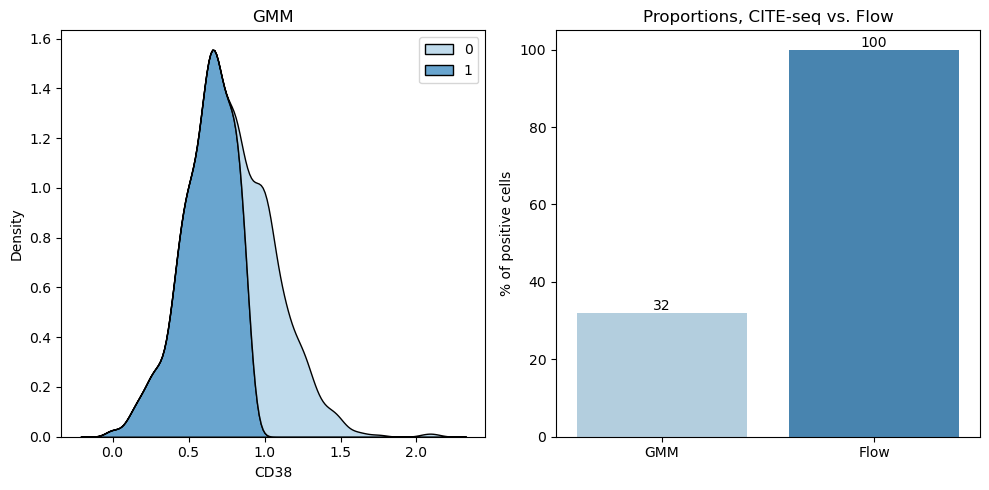

Silhuette score: 0.5940911884437272
Percentage of positive cells, based on GMM: 6.091846298031865


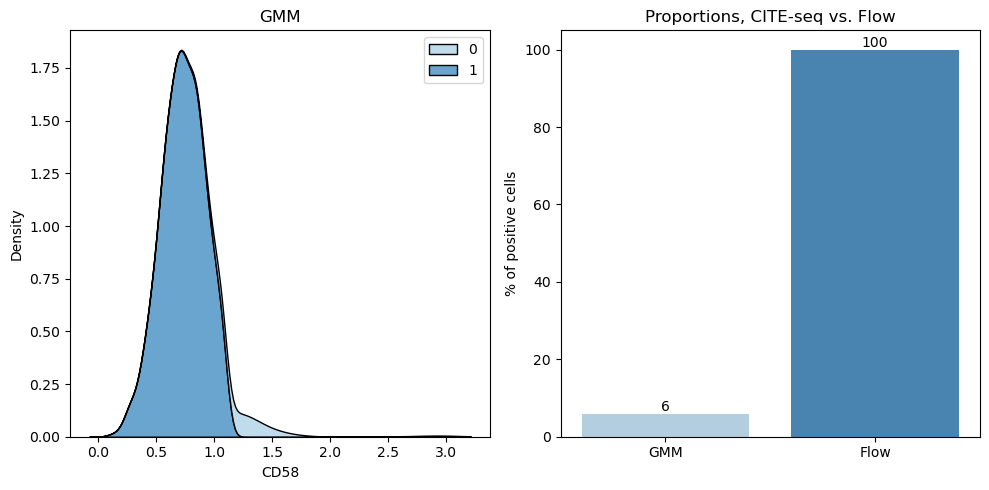

In [49]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.526127865093167
Percentage of positive cells, based on GMM: 86.5979381443299


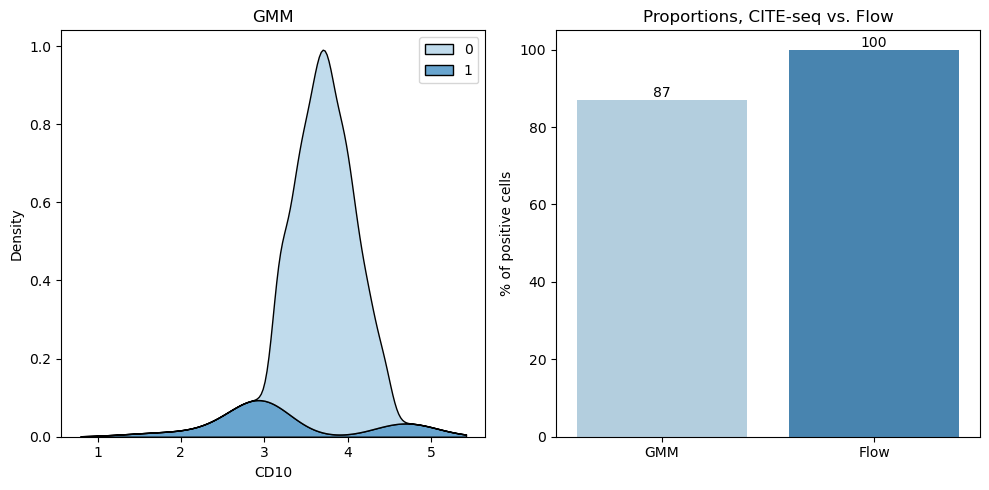

Silhuette score: 0.5535442915883672
Percentage of positive cells, based on GMM: 60.35613870665417


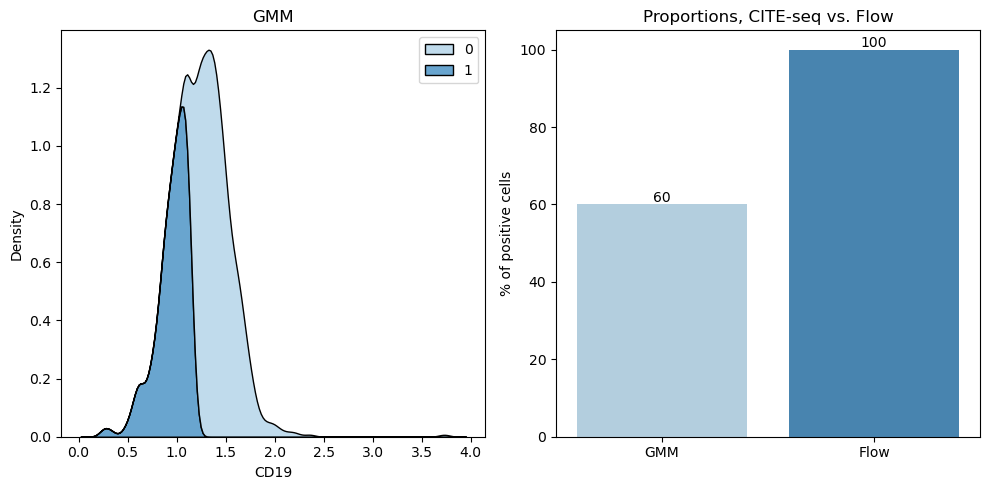

Silhuette score: 0.5607593567671326
Percentage of positive cells, based on GMM: 48.92221180880975


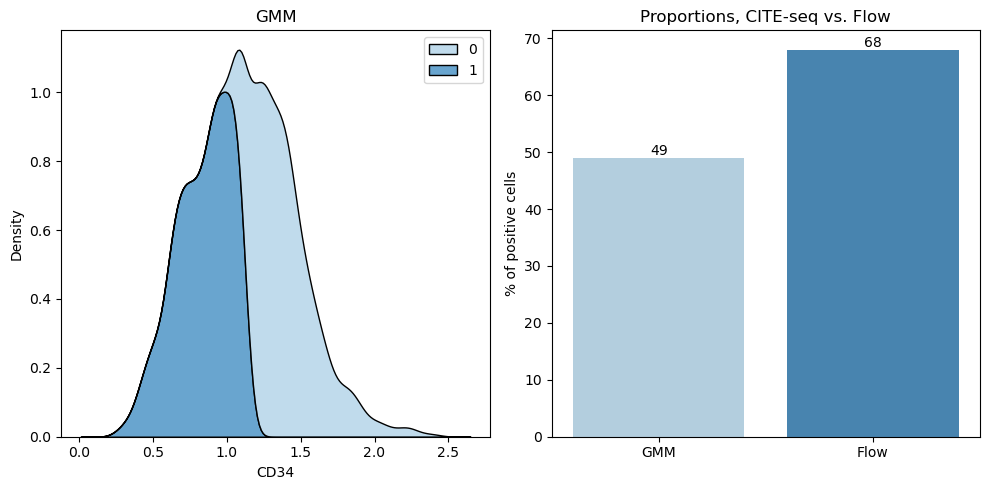

Silhuette score: 0.5716840864118458
Percentage of positive cells, based on GMM: 35.520149953139644


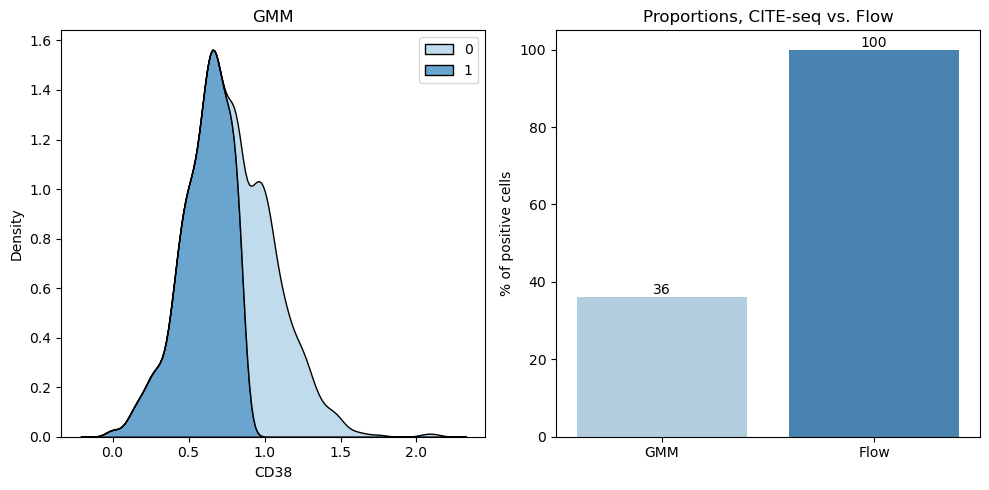

Silhuette score: 0.791499999605645
Percentage of positive cells, based on GMM: 1.0309278350515463


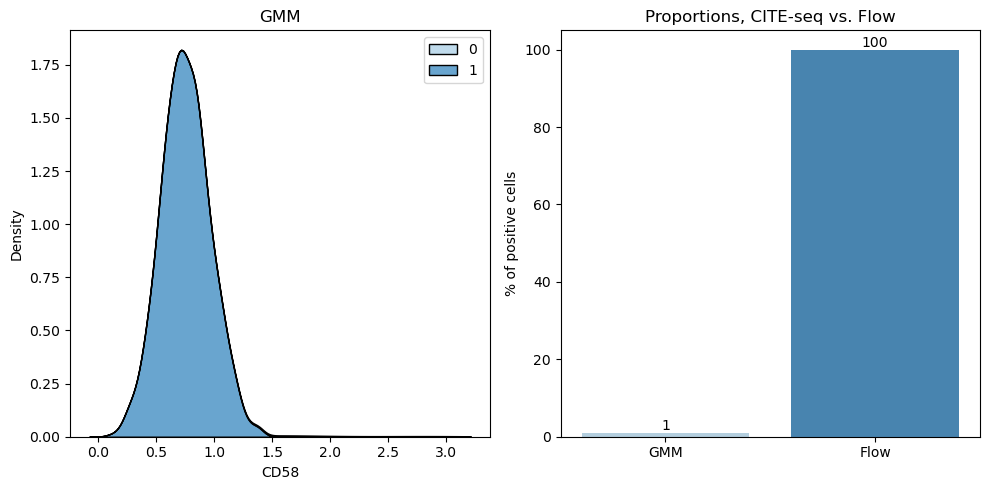

In [50]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_full = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

## DSB Normalized

In [51]:
prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACGGGTCTACTTAC-1-119,5.235474,6.765774,3.392691,0.808834,3.707282,2.972158,9.732417,12.509436,2.973591,-1.510255,...,0.891578,1.754948,2.642372,0.046999,5.641718,6.519819,1.705478,1.870252,2.644428,2.188816
AAAGATGAGGAGTAGA-1-119,1.098276,7.259014,1.393066,-0.646733,-1.678327,-0.076621,1.911605,4.575176,-0.277374,-1.510255,...,0.454759,-1.025544,-0.143150,-0.384310,7.088585,5.934313,0.767981,0.640264,0.505158,1.311661
AAAGCAACACAGACTT-1-119,1.726878,5.649791,2.285491,-0.962689,0.447542,-0.641244,3.161980,4.131022,-0.277374,-0.705994,...,0.454759,-0.674252,0.707019,-0.850160,6.819550,6.734242,0.222203,0.174821,-1.242754,1.311661
AAAGCAACAGGGTATG-1-119,2.258353,8.020568,-1.144322,-1.139418,0.796405,0.182565,2.358955,7.488725,0.597070,0.028237,...,-1.055551,1.059134,-0.560621,-0.384310,8.081855,4.882566,1.259085,1.870252,0.505158,1.311661
AAAGCAACATCACAAC-1-119,3.047345,9.353902,1.068179,-0.799064,0.077523,-0.076621,5.328226,4.131022,-0.277374,1.329014,...,0.454759,-0.344264,0.225084,-0.384310,2.581179,5.473848,1.914316,2.235003,1.982996,4.218381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGCCAACAG-1-119,0.810795,9.314544,-0.924099,0.096173,-0.316384,2.041421,8.672638,2.642952,-0.762677,-0.705994,...,-0.513795,-1.401081,-0.344923,0.824153,3.034776,6.681586,-0.391966,3.224028,-1.242754,5.373164
TTTGGTTAGAGCTGCA-1-119,1.609993,6.275143,0.298399,-0.244180,1.439466,-0.950627,2.774324,7.173814,0.994076,0.028237,...,1.688773,-0.344264,0.852458,-0.850160,3.463843,6.574390,1.487356,-0.865119,0.505158,-1.362772
TTTGTCAAGGTTCCTA-1-119,1.726878,7.955753,-0.524583,2.300853,1.439466,-0.076621,5.455982,5.400477,1.368383,1.329014,...,1.301905,-0.674252,0.225084,0.824153,4.980019,6.628307,2.492271,5.959399,-0.329018,3.618855
TTTGTCAGTATCACCA-1-119,3.556360,8.214930,3.756397,1.921420,0.077523,0.662341,5.580991,4.997655,0.174433,1.911199,...,0.454759,1.059134,-0.792311,0.046999,7.088585,7.546330,1.487356,3.224028,-0.329018,5.600803


In [52]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_dsb.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


Silhuette score: 0.5100886
Percentage of positive cells: 32.42736644798501


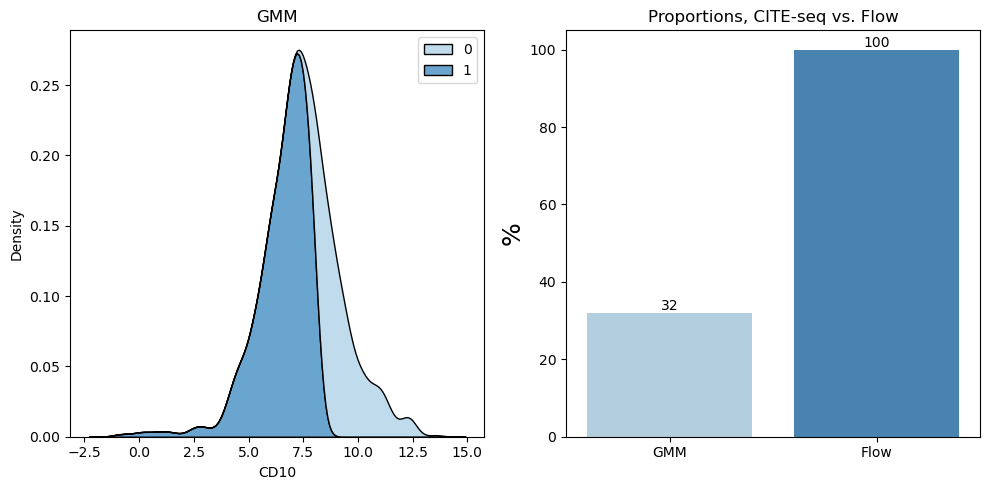

Silhuette score: 0.53446275
Percentage of positive cells: 40.11246485473289


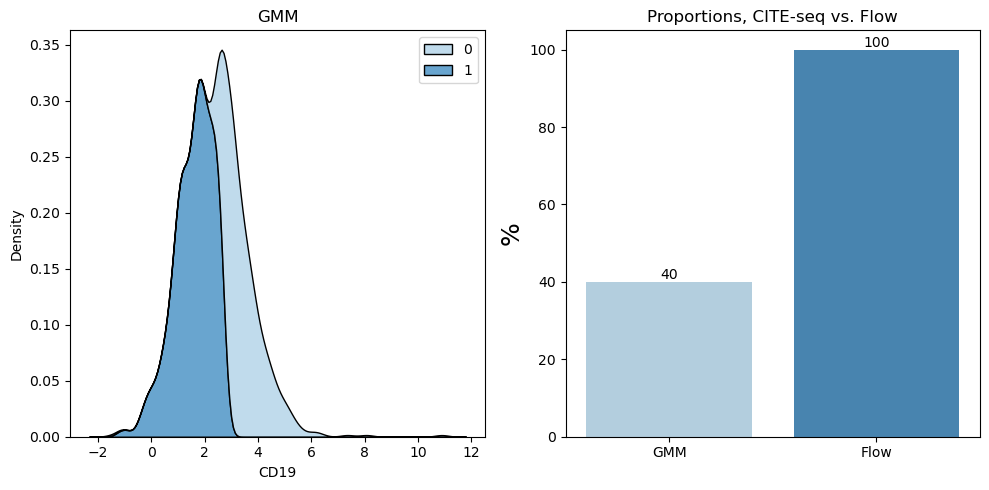

Silhuette score: 0.5536002
Percentage of positive cells: 31.208997188378635


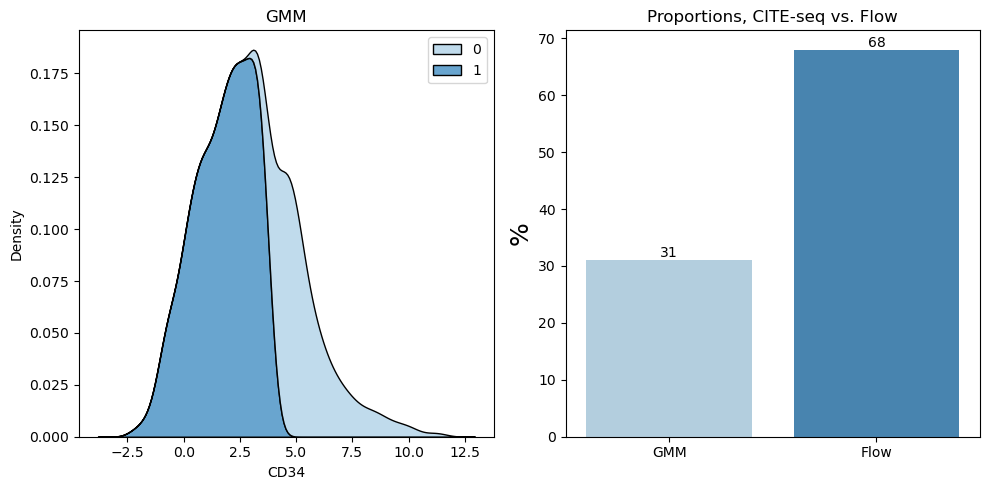

Silhuette score: 0.56336236
Percentage of positive cells: 34.864104967197754


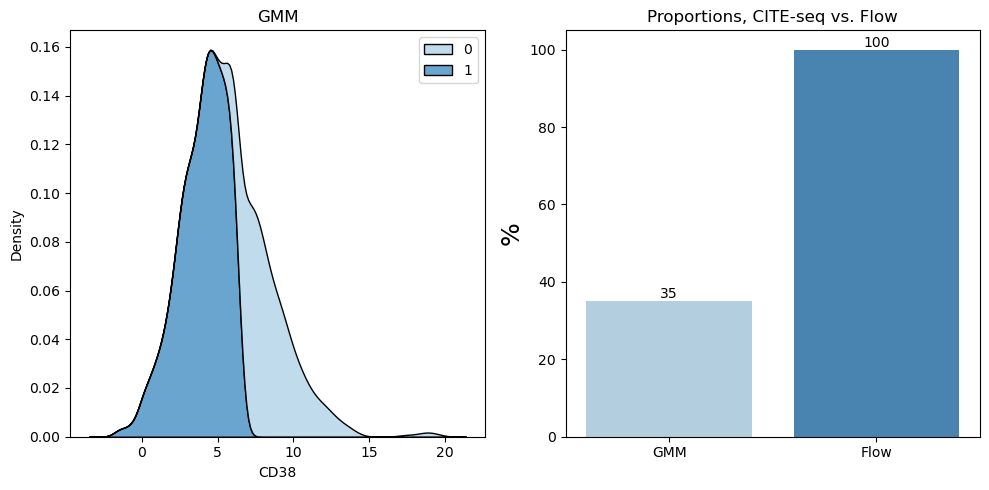

Silhuette score: 0.60362357
Percentage of positive cells: 7.497656982193064


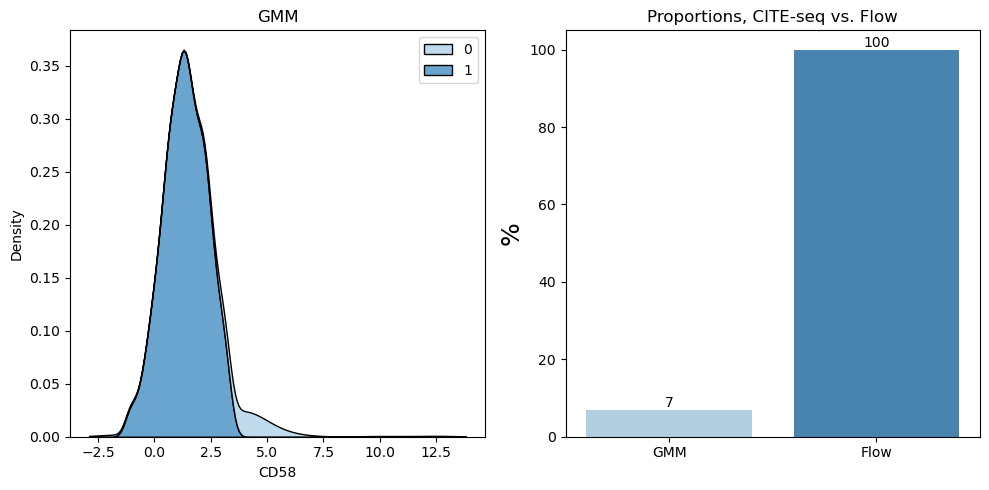

In [53]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_full = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5100886
Percentage of positive cells: 32.42736644798501


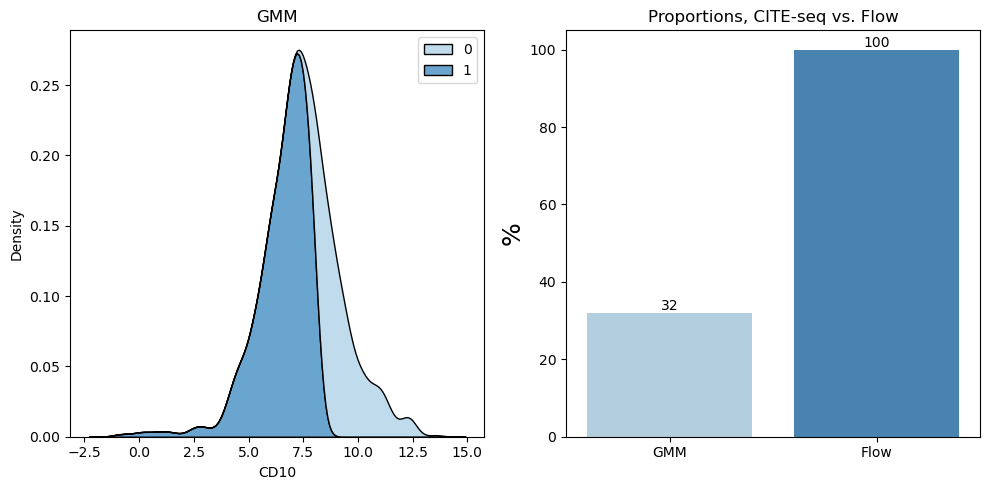

Silhuette score: 0.53446275
Percentage of positive cells: 40.11246485473289


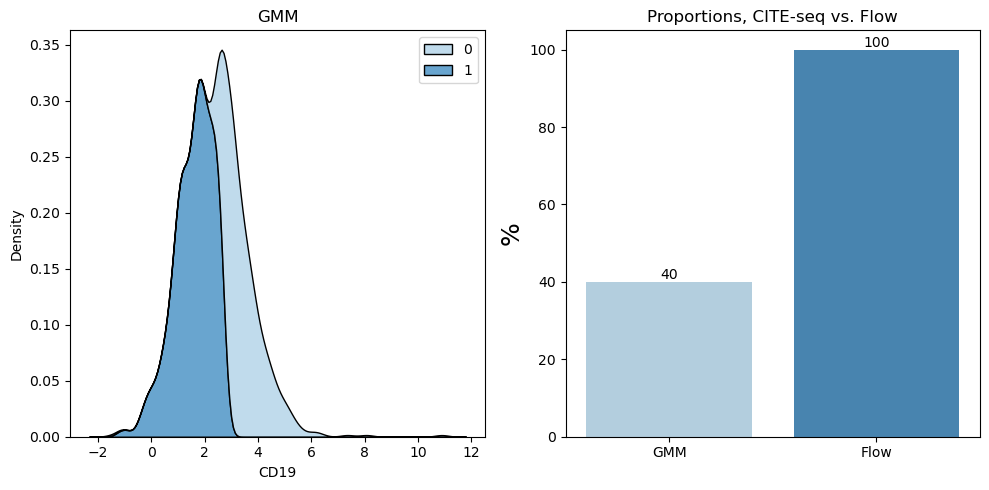

Silhuette score: 0.5536002
Percentage of positive cells: 31.208997188378635


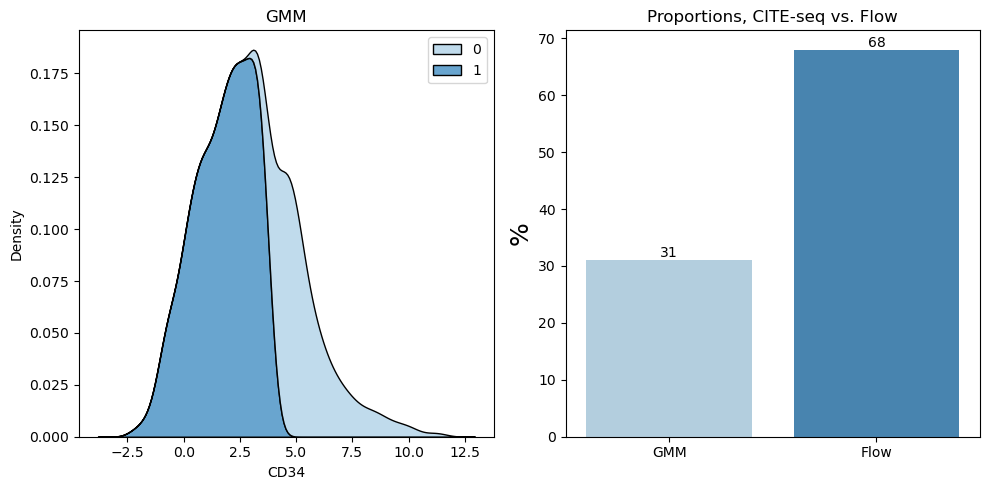

Silhuette score: 0.56336236
Percentage of positive cells: 34.864104967197754


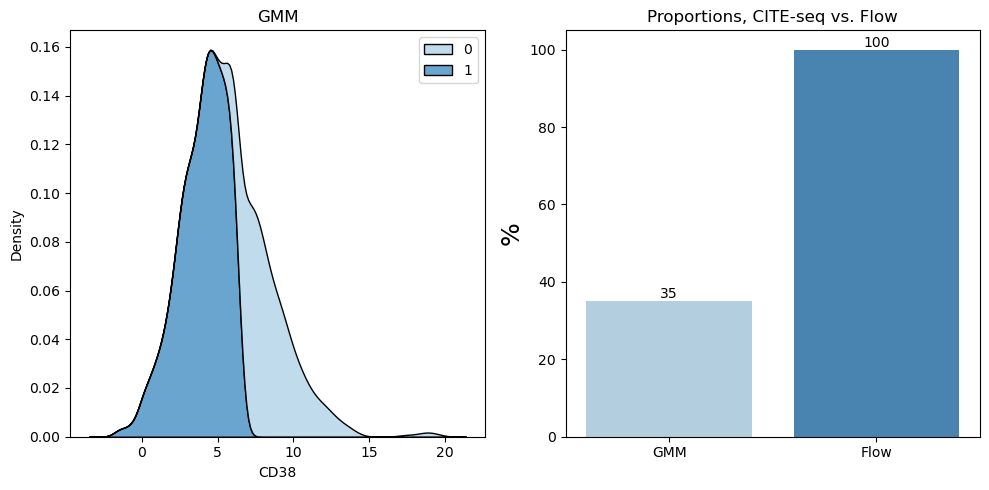

Silhuette score: 0.60362357
Percentage of positive cells: 7.497656982193064


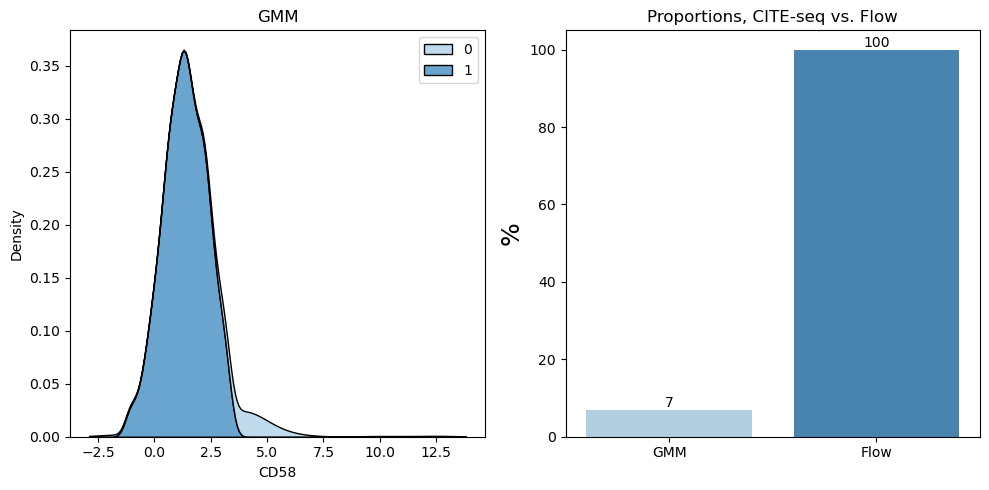

In [54]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_spher = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5115619
Percentage of positive cells: 31.021555763823805


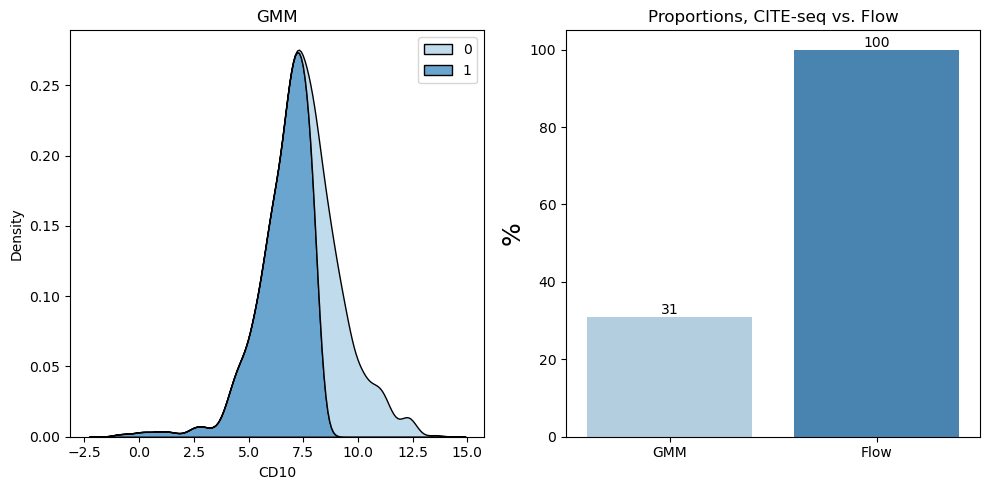

Silhuette score: 0.51941854
Percentage of positive cells: 35.988753514526714


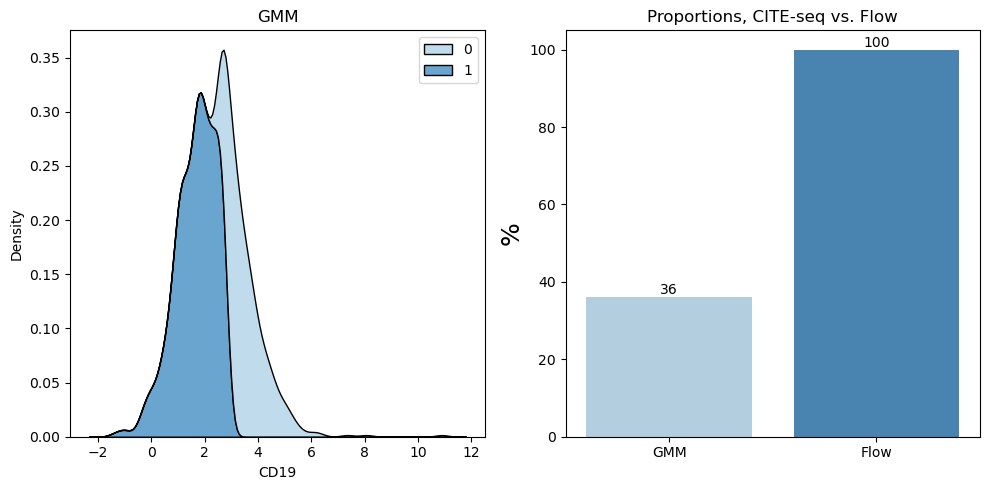

Silhuette score: 0.53698456
Percentage of positive cells: 25.117150890346768


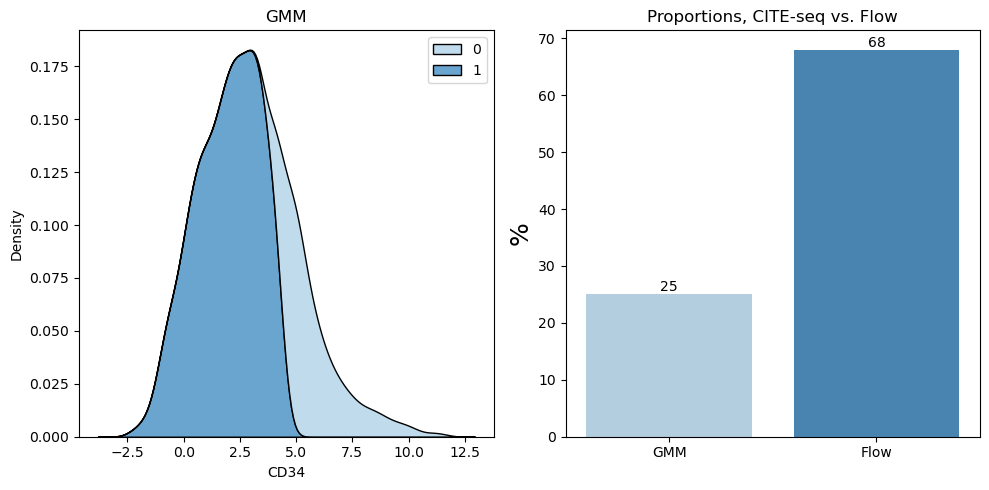

Silhuette score: 0.55253625
Percentage of positive cells: 20.712277413308342


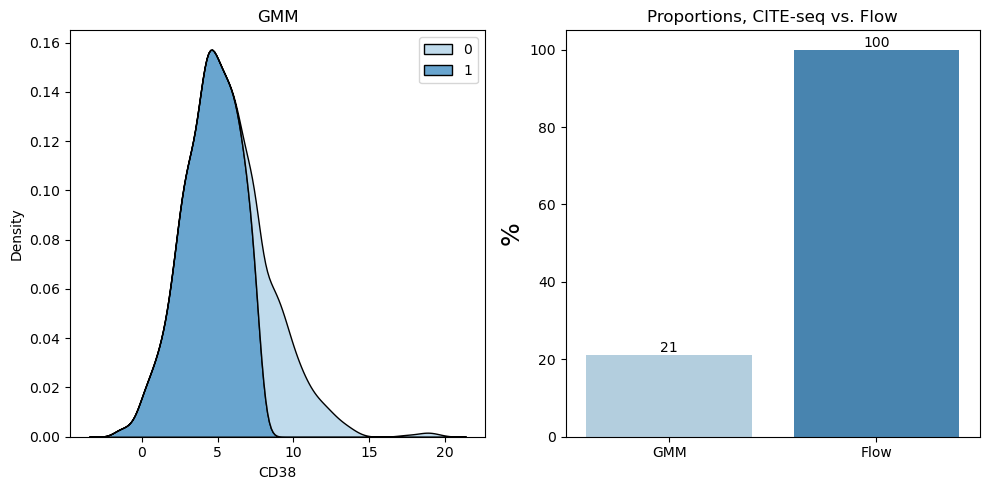

Silhuette score: 0.8610542
Percentage of positive cells: 0.37488284910965325


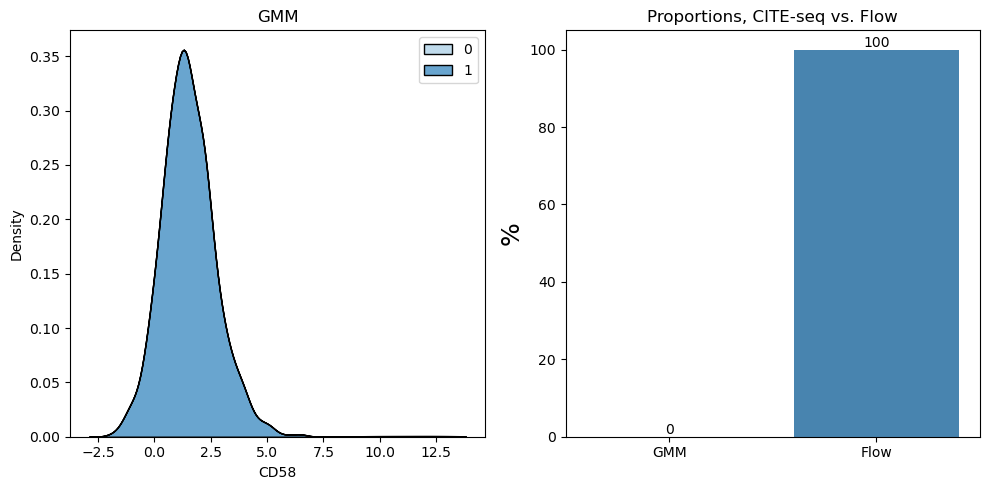

In [55]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5100886
Percentage of positive cells: 32.42736644798501


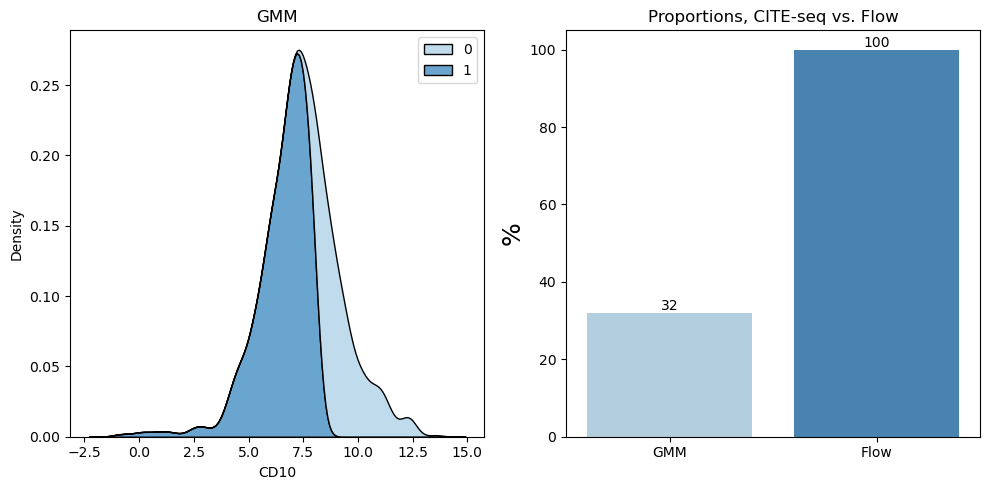

Silhuette score: 0.53446275
Percentage of positive cells: 40.11246485473289


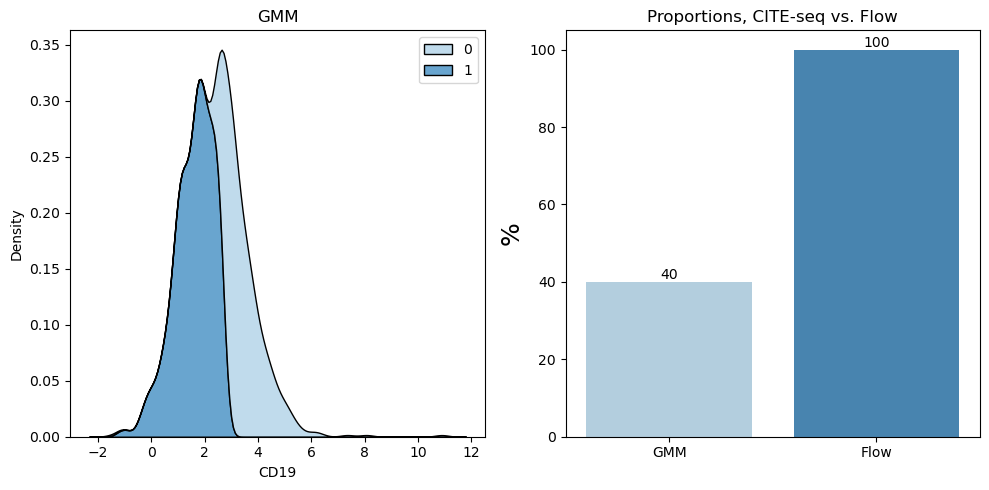

Silhuette score: 0.5536002
Percentage of positive cells: 31.208997188378635


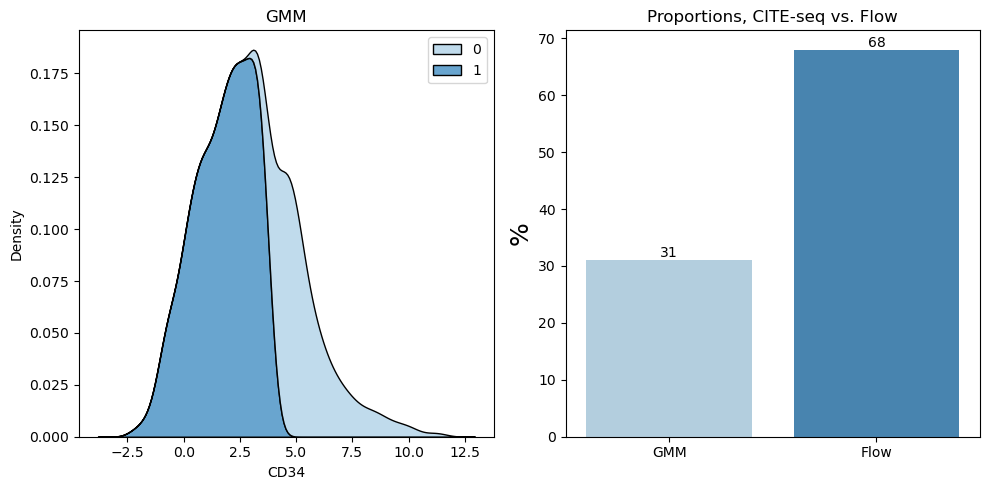

Silhuette score: 0.56336236
Percentage of positive cells: 34.864104967197754


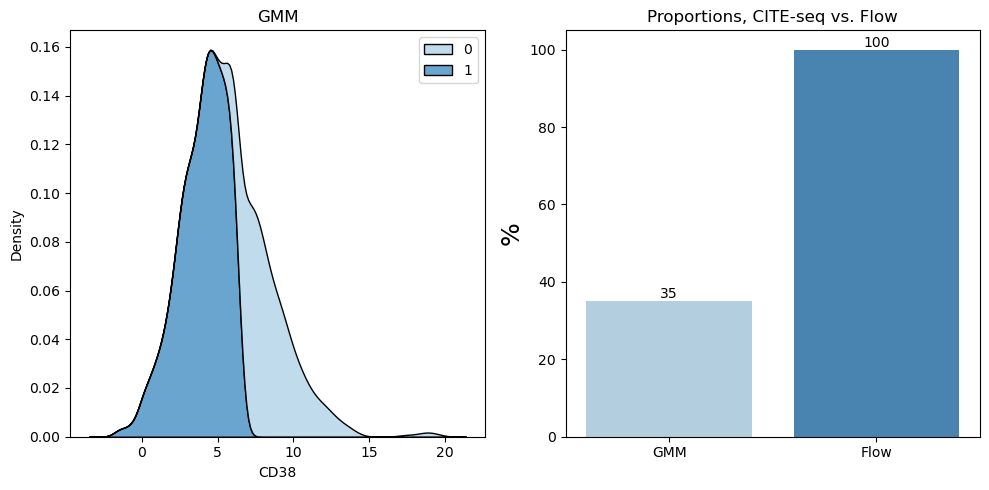

Silhuette score: 0.60362357
Percentage of positive cells: 7.497656982193064


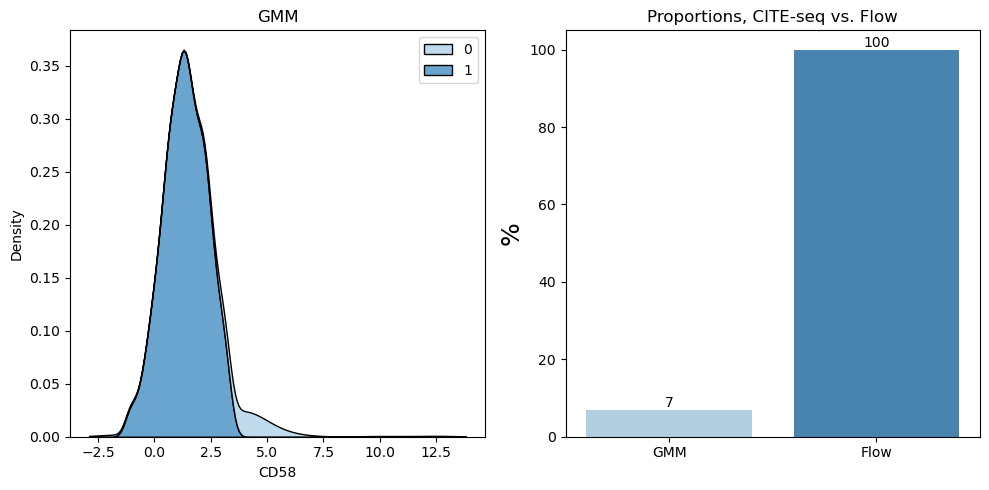

In [56]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_diag = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

## Silhuette scores

In [57]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[0]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[0]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[0]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[0]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[0]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[0]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[0]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[0]]
      };

silhuette_df= pd.DataFrame(data=silhuettes)

silhuette_df.T

,0
silhuette_scores_dsb_diag,0.510089
silhuette_scores_dsb_spher,0.510089
silhuette_scores_dsb_tied,0.511562
silhuette_scores_dsb_full,0.510089
silhuette_scores_clr_diag,0.526128
silhuette_scores_clr_spher,0.526128
silhuette_scores_clr_tied,0.531804
silhuette_scores_clr_full,0.526128


In [58]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[1]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[1]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[1]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[1]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[1]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[1]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[1]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[1]]
      };

silhuette_df1= pd.DataFrame(data=silhuettes)

silhuette_df1.T

,0
silhuette_scores_dsb_diag,0.534463
silhuette_scores_dsb_spher,0.534463
silhuette_scores_dsb_tied,0.519419
silhuette_scores_dsb_full,0.534463
silhuette_scores_clr_diag,0.553544
silhuette_scores_clr_spher,0.553544
silhuette_scores_clr_tied,0.558098
silhuette_scores_clr_full,0.553544


In [59]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[2]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[2]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[2]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[2]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[2]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[2]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[2]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[2]]
      };

silhuette_df2= pd.DataFrame(data=silhuettes)

silhuette_df2.T

,0
silhuette_scores_dsb_diag,0.553600
silhuette_scores_dsb_spher,0.553600
silhuette_scores_dsb_tied,0.536985
silhuette_scores_dsb_full,0.553600
silhuette_scores_clr_diag,0.560759
silhuette_scores_clr_spher,0.560759
silhuette_scores_clr_tied,0.559521
silhuette_scores_clr_full,0.560759


In [60]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[3]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[3]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[3]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[3]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[3]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[3]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[3]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[3]]
      };

silhuette_df3= pd.DataFrame(data=silhuettes)

silhuette_df3.T

,0
silhuette_scores_dsb_diag,0.563362
silhuette_scores_dsb_spher,0.563362
silhuette_scores_dsb_tied,0.552536
silhuette_scores_dsb_full,0.563362
silhuette_scores_clr_diag,0.571684
silhuette_scores_clr_spher,0.571684
silhuette_scores_clr_tied,0.563651
silhuette_scores_clr_full,0.571684


In [61]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[4]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[4]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[4]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[4]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[4]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[4]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[4]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[4]]
      };

silhuette_df4= pd.DataFrame(data=silhuettes)

silhuette_df4.T

,0
silhuette_scores_dsb_diag,0.603624
silhuette_scores_dsb_spher,0.603624
silhuette_scores_dsb_tied,0.861054
silhuette_scores_dsb_full,0.603624
silhuette_scores_clr_diag,0.791500
silhuette_scores_clr_spher,0.791500
silhuette_scores_clr_tied,0.594091
silhuette_scores_clr_full,0.791500


In [62]:
column_names


['CD10', 'CD19', 'CD34', 'CD38', 'CD58']

In [64]:
the_df= pd.concat([silhuette_df,silhuette_df1,silhuette_df2,silhuette_df3,silhuette_df4], axis=0)


In [65]:
the_df = the_df.T

the_df

,0,0,0,0,0
silhuette_scores_dsb_diag,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_dsb_spher,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_dsb_tied,0.511562,0.519419,0.536985,0.552536,0.861054
silhuette_scores_dsb_full,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_clr_diag,0.526128,0.553544,0.560759,0.571684,0.791500
silhuette_scores_clr_spher,0.526128,0.553544,0.560759,0.571684,0.791500
silhuette_scores_clr_tied,0.531804,0.558098,0.559521,0.563651,0.594091
silhuette_scores_clr_full,0.526128,0.553544,0.560759,0.571684,0.791500


In [66]:
the_df.columns = column_names

In [70]:
the_df= the_df.T


In [71]:
the_df

,CD10,CD19,CD34,CD38,CD58
silhuette_scores_dsb_diag,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_dsb_spher,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_dsb_tied,0.511562,0.519419,0.536985,0.552536,0.861054
silhuette_scores_dsb_full,0.510089,0.534463,0.553600,0.563362,0.603624
silhuette_scores_clr_diag,0.526128,0.553544,0.560759,0.571684,0.791500
silhuette_scores_clr_spher,0.526128,0.553544,0.560759,0.571684,0.791500
silhuette_scores_clr_tied,0.531804,0.558098,0.559521,0.563651,0.594091
silhuette_scores_clr_full,0.526128,0.553544,0.560759,0.571684,0.791500


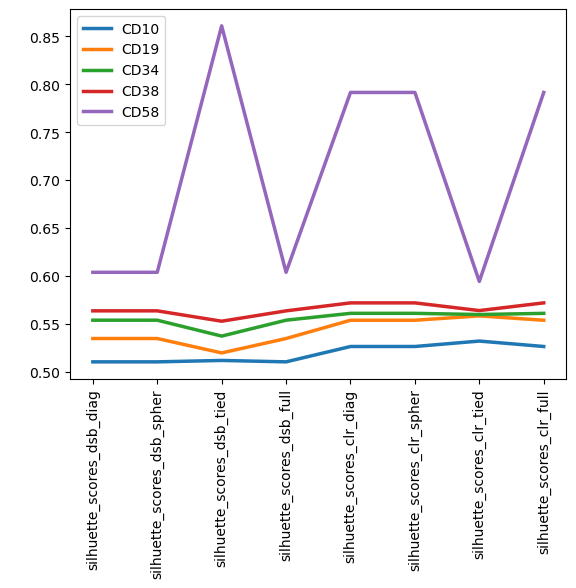

In [72]:
a = sns.lineplot(data=the_df["CD10"], palette=['red'], linewidth=2.5, label='CD10')
a = sns.lineplot(data=the_df["CD19"], palette=['green'], linewidth=2.5, label='CD19')
a = sns.lineplot(data=the_df["CD34"],palette=['black'],linewidth=2.5, label='CD34')
a = sns.lineplot(data=the_df["CD38"],palette=['blue'],linewidth=2.5, label='CD38')
a = sns.lineplot(data=the_df["CD58"],palette=['violet'],linewidth=2.5, label='CD58')

a.set_xticklabels(a.get_xticklabels(),rotation=90) ;
plt.ylabel(" ");



- Silhuette scores are calculated for each protein, and compared between normalization mathods & different covariance types (diagonal, spherical, full)